Ridge regression
---

Exercise - Basic feature engineering for the house prices data
---

> **Exercise**: (A) load the house prices data from `house-prices.csv` (B) plot the distribution of the continuous variables using histograms: you should see that many have a skewed one (C) create a `preprocess(df)` function which performs (C.1) one-hot encoding (C.2) fill missing values (C.3) apply a **log-transform** to every continuous feature and (C.4) add their **polynomial features** of degree 2, 3 and 0.5 (square root). Finally (D) create the X/y numpy arrays - use the `np.log10()` of the sale price as the target variable.

**Hint**: The logarithm of zero doesn't exist, so we have to make sure that there are no zero values in the continuous columns when applying the log-transform. To achieve this, we can use `np.log(x+1)` (or simply `np.log1p(x)` which is equivalent) which will leave zero values untransformed i.e. `log(1)=0`

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# (A) Load the data
data_df = pd.read_csv(os.path.join('data','house-prices.csv'))
data_df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000


In [3]:
# Continuous features from the documentation
continuous = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
    'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
    'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
    '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

/home/xavier/anaconda3/envs/exts-ml/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/xavier/anaconda3/envs/exts-ml/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


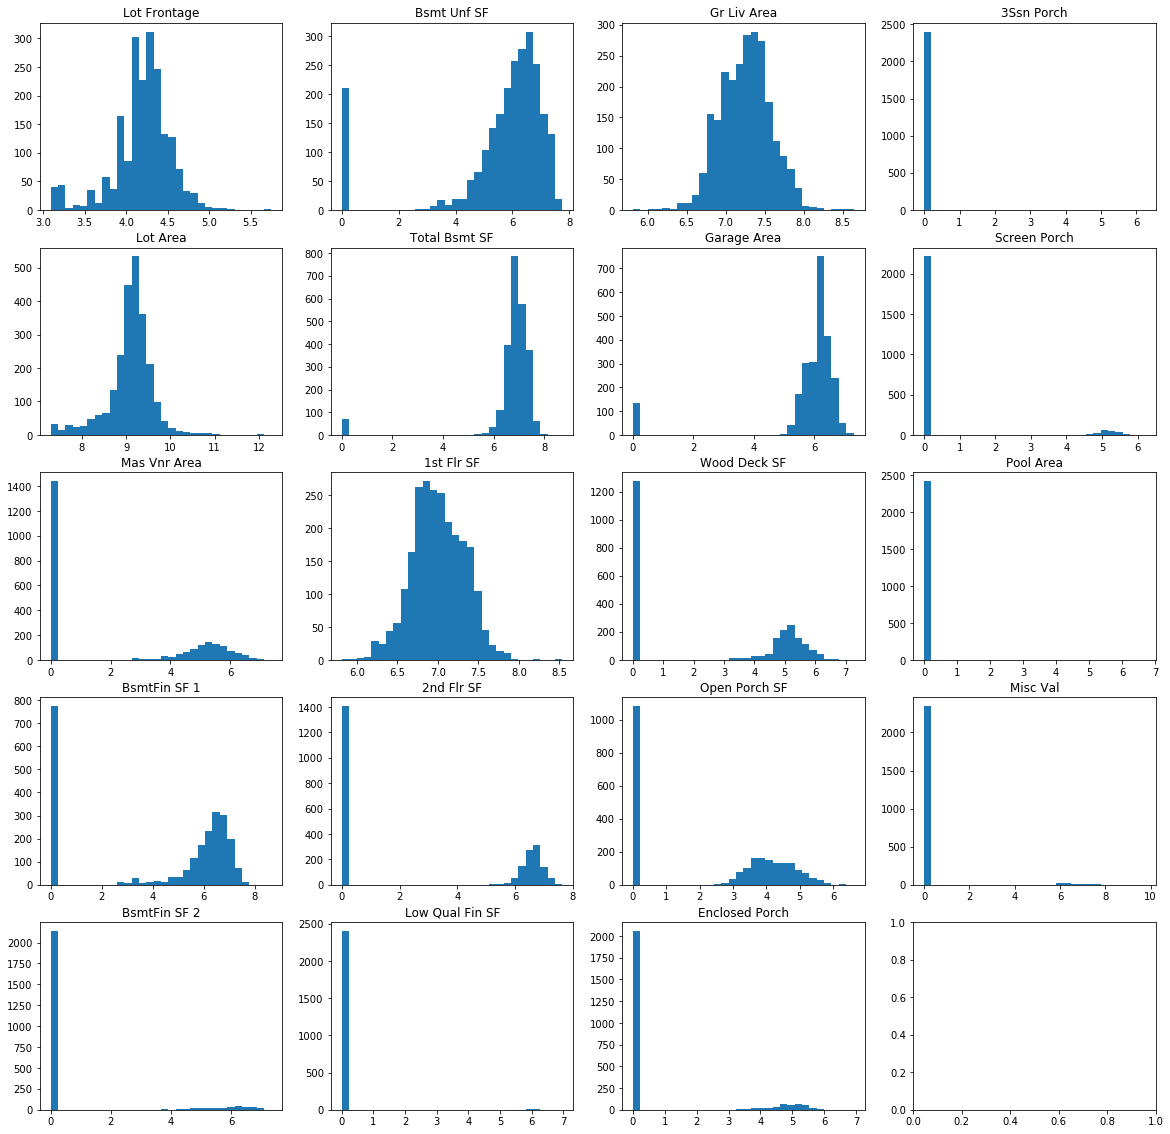

In [4]:
# (B) Plot the distribution of the continuous variables using histograms




fig, axs = plt.subplots(5, 4, figsize=(20,20))


for i in range(0,19):
    row  = int(i/5)
    line = i-row*5
    
    x = data_df[continuous[i]].values
    axs[line, row].hist(np.log1p(x), bins=30)
    axs[line, row].set_title(continuous[i])
    



plt.show()


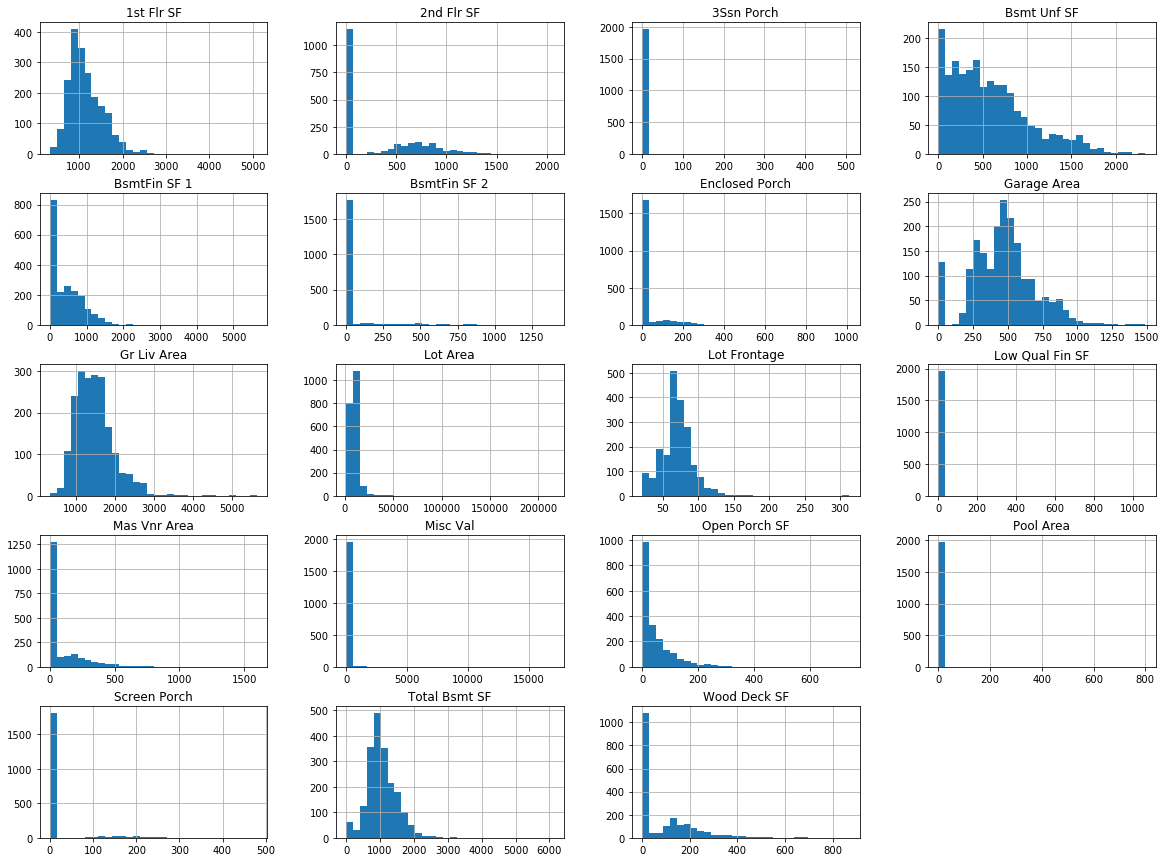

In [5]:
continuous_df = data_df[continuous].dropna();
continuous_df.hist(figsize=(20, 15), bins=30, layout=(-1, 4));

In [6]:
# (C) Preprocessing function

def preprocess(df):
    # Work on a copy
    df = df.copy()

    # One-hot encoding
    df = pd.get_dummies(df, dummy_na=True)

    # Fill missing values
    for c in df.columns:
        df[c] = df[c].fillna(df[c].median())

    # (C.3) Apply log-transform
    df[continuous] = np.log1p(df[continuous])
    
    # (C.4) Add polynomial features
    for c in continuous:
        for d in [0.5, 2, 3]:
            name = '{}**{}'.format(c, d)
            df[name] = df[c]**d
        
    return df

preprocessed_df = preprocess(data_df)
preprocessed_df.head(2)



,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,3Ssn Porch**3,Screen Porch**0.5,Screen Porch**2,Screen Porch**3,Pool Area**0.5,Pool Area**2,Pool Area**3,Misc Val**0.5,Misc Val**2,Misc Val**3
0,484,528275070,60,4.234107,9.082052,7,5,2000,2000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2586,535305120,20,4.330733,9.227296,6,6,1951,1951,6.259581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# (D) Create X, y
X = preprocessed_df.drop('SalePrice', axis=1).values
y = np.log10(preprocessed_df['SalePrice'])



Exercise - Tune Ridge regression
---

> **Exercise**: Fit a ridge regression model and tune its alpha value using grid search. Use the train/test set methodology with a 50/50 split. Print the optimal alpha value and the test MSE/MAE scores.

**Hint**: Don't forget to standardize the input data.

In [8]:
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.5, random_state=0)
print('Train:', X_tr.shape, y_tr.shape) # (1215, 347) (1215,)
print('Test:', X_te.shape, y_te.shape) # (1215, 347) (1215,)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

Train: (1215, 404) (1215,)
Test: (1215, 404) (1215,)


In [87]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

# Store variables in an array
gs_results = []

for alpha in np.logspace(-1,4,num=100):
    # create and fit Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_rescaled, y_tr)
    
    gs_results.append({
        'alpha': alpha,
        'train_mae': MAE(10**y_tr,10**ridge.predict(X_tr_rescaled)),
        'train_mse': MSE(y_tr,ridge.predict(X_tr_rescaled)),
        'test_mae': MAE(10**y_te,10**ridge.predict(X_te_rescaled)),
        'test_mse': MSE(y_te,ridge.predict(X_te_rescaled)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,test_mae,test_mse,train_mae,train_mse
0,0.100000,15301.834238,0.004821,10517.035663,0.001279
1,0.112332,15290.058676,0.004811,10520.623780,0.001279
2,0.126186,15277.963804,0.004800,10524.386869,0.001280
3,0.141747,15265.700153,0.004788,10528.467221,0.001281
4,0.159228,15253.537456,0.004775,10532.739988,0.001282


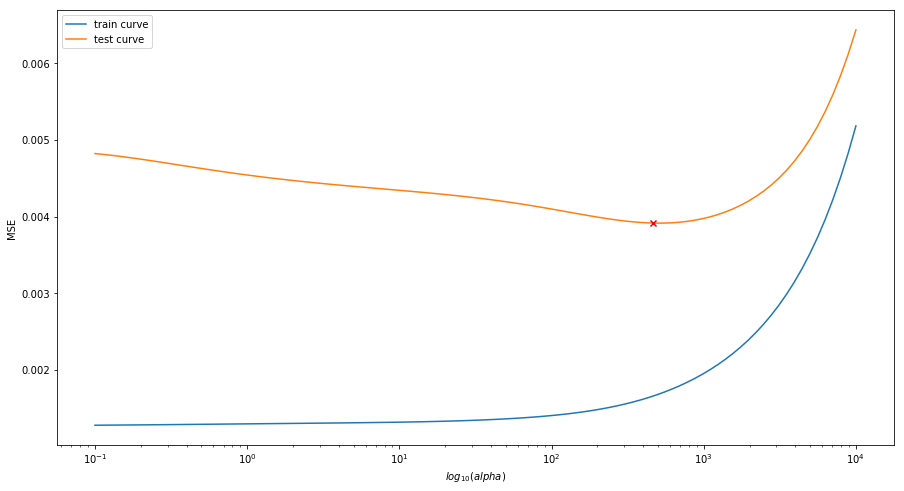

In [92]:
# Plot the validation curves
plt.figure(figsize=(15,8))
plt.semilogx(gs_results['alpha'], gs_results['train_mse'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mse'], label='test curve')
plt.scatter(best_result.alpha, best_result.test_mse, marker='x', c='red', zorder=10)
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [86]:
# Get entry with the best test MSE
best_result = gs_results.loc[gs_results.test_mse.idxmin()]

# Print the details
print('Best alpha: {:.1e}'.format(best_result.alpha)) 
print('Test MSE: {:.4f}'.format(best_result.test_mse))
print('Test MAE: {:,.0f}$'.format(best_result.test_mae))

Best alpha: 4.6e+02
Test MSE: 0.0039
Test MAE: 14,055$
